In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import seaborn as sns

test_csv_path = '/kaggle/input/morph/Dataset/Index/Test.csv'
test_image_dir = '/kaggle/input/morph/Dataset/Images/Test'
model_path = '/kaggle/input/age-detector/other/default/1/age_detection_model_1.h5'
image_size = (180, 180)

test_csv = pd.read_csv(test_csv_path)
test_csv = test_csv.set_index('filename')


model = load_model(model_path, compile=False)

filenames = test_csv.index.tolist()
X = np.zeros((len(filenames), *image_size, 3), dtype=np.float32)

for i, fname in enumerate(filenames):
    img_path = os.path.join(test_image_dir, fname)
    img = load_img(img_path, target_size=image_size)
    img_array = img_to_array(img) / 255.0
    X[i] = img_array

#Get predictions
y_pred = model.predict(X, batch_size=64).flatten()
y_true = test_csv['age'].values
genders = test_csv['gender'].values

df_results = pd.DataFrame({
    'filename': filenames,
    'true_age': y_true,
    'pred_age': y_pred,
    'gender': genders
})

#Labels mapping
gender_map = {0: 'Male', 1: 'Female'}
df_results['gender'] = df_results['gender'].map(gender_map)


#MAE over gender
grouped = df_results.groupby('gender').apply(
    lambda df: mean_absolute_error(df['true_age'], df['pred_age'])
).reset_index()
grouped.columns = ['Gender', 'MAE']

79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 337ms/step


/tmp/ipykernel_35/4098875523.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_results.groupby('gender').apply(


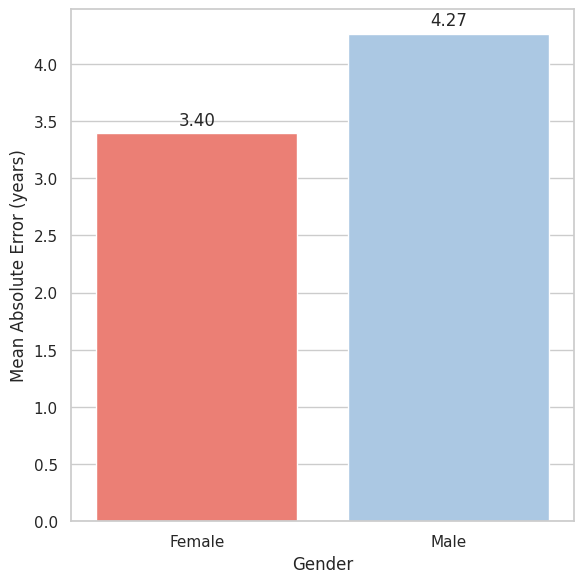

In [13]:
#Style
sns.set(style="whitegrid")
color_palette = {
    'Female': '#FF6F61', 
    'Male': '#A2C8EC'   
}


#Graph
plt.figure(figsize=(6, 6))
ax = sns.barplot(data=grouped, x='Gender', y='MAE', palette=color_palette)
ax.set_title('', fontsize=14)
ax.set_ylabel('Mean Absolute Error (years)', fontsize=12)
ax.set_xlabel('Gender', fontsize=12)
ax.bar_label(ax.containers[0], fmt='%.2f', padding=3)
plt.tight_layout()
plt.show()

/tmp/ipykernel_35/2623596229.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_mae = df_results.groupby('age_bin')['abs_error'].mean().reset_index()
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


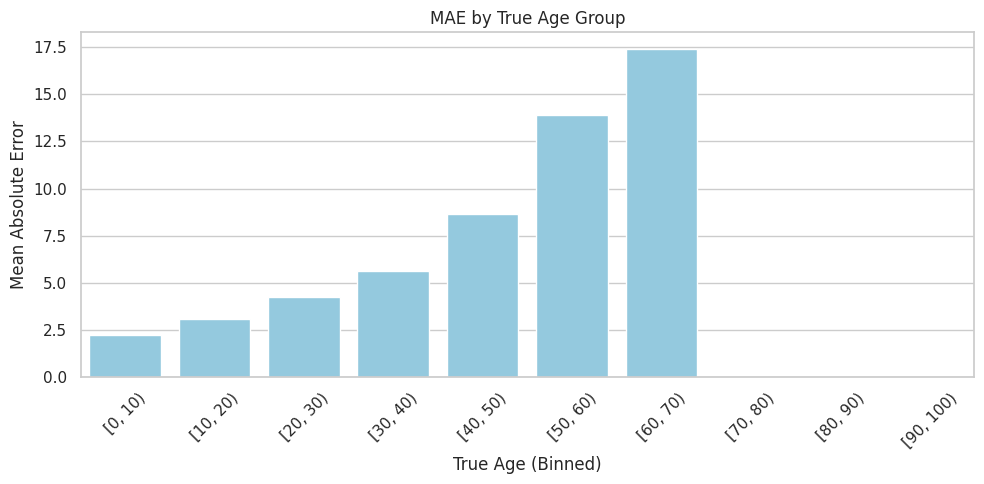

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#MAE CHANGING OVER AGES
df_results['abs_error'] = np.abs(df_results['true_age'] - df_results['pred_age'])

df_results['age_bin'] = pd.cut(df_results['true_age'], bins=range(0, 101, 10), right=False)

age_mae = df_results.groupby('age_bin')['abs_error'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=age_mae, x='age_bin', y='abs_error', color='skyblue')
plt.xticks(rotation=45)
plt.xlabel('True Age (Binned)')
plt.ylabel('Mean Absolute Error')
plt.title('MAE by True Age Group')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


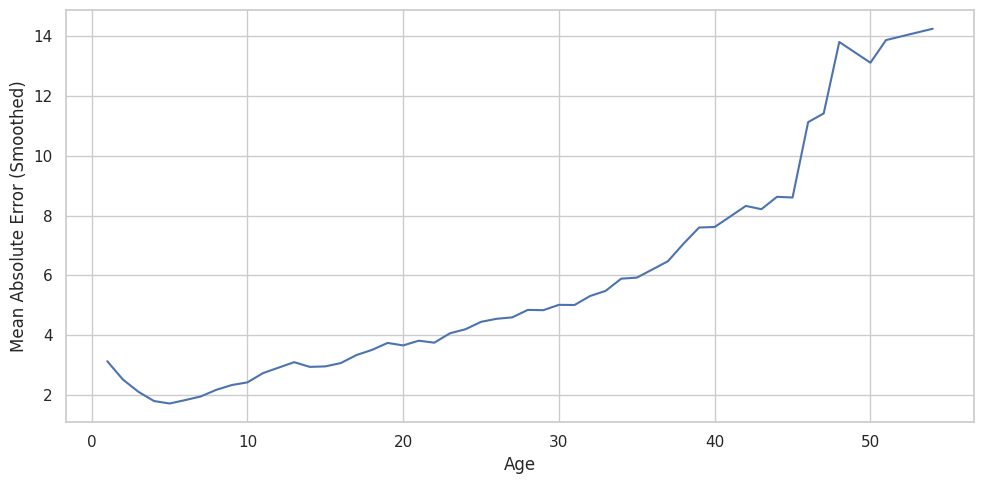

In [16]:
#MAE Smoothed
rolling = (
    df_results
    .groupby('true_age')['abs_error']
    .mean()
    .rolling(window=3, center=True)
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 5))
sns.lineplot(data=rolling, x='true_age', y='abs_error')
plt.xlabel('Age')
plt.ylabel('Mean Absolute Error (Smoothed)')
plt.title('')
plt.grid(True)
plt.tight_layout()
plt.show()
